In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digits/sample_submission.csv
/kaggle/input/digits/9.png
/kaggle/input/digits/3.png
/kaggle/input/digits/8.png
/kaggle/input/digits/train.csv
/kaggle/input/digits/test.csv
/kaggle/input/digits/0.png


# Handwritten numeral recognition

## Train

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 1. 加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 数据归一化到 [-1, 1]
])

In [5]:
# 改进的数据增强
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.2, 0.2)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 42278592.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1127777.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9040085.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3967207.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# 2. 定义 CNN 模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
model = CNN().to(device)

In [10]:
# 3. 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# 4. 训练模型
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/5], Loss: 0.5494
Epoch [2/5], Loss: 0.1774
Epoch [3/5], Loss: 0.1265
Epoch [4/5], Loss: 0.1132
Epoch [5/5], Loss: 0.0948


In [12]:
# 5. 测试模型
model.eval()  # 设置为评估模式
correct = 0
total = 0
with torch.no_grad():  # 禁用梯度计算
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 97.92%


In [13]:
# 6. 保存模型
torch.save(model.state_dict(), "mnist_cnn.pth")
print("Model saved to mnist_cnn.pth")

Model saved to mnist_cnn.pth


## Predict

In [14]:
import torch
from torchvision import transforms
from PIL import Image, ImageOps  # 这里确保导入 Image 和 ImageOps
import matplotlib.pyplot as plt
import torch.nn as nn

In [15]:
# 定义模型结构（与训练时一致）
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 新增一层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # 修改全连接层大小
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)  # Dropout 防止过拟合

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_cnn.pth", map_location=device))
model.eval()

/tmp/ipykernel_23/2667161290.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_cnn.pth", map_location=device))


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
# 改进的图片预处理函数
def preprocess_image(image_path):
    """
    预处理真实图片：
    - 转换为灰度图
    - 裁剪白边
    - 调整大小到 28x28
    - 归一化
    """
    transform = transforms.Compose([
        transforms.Grayscale(),  # 转为灰度图
        transforms.Resize((28, 28)),  # 调整大小
        transforms.ToTensor(),  # 转为张量
        transforms.Normalize((0.5,), (0.5,))  # 归一化到 [-1, 1]
    ])
    
    image = Image.open(image_path)  # 打开图片
    image = ImageOps.invert(image.convert("L"))  # 转为灰度图并反转黑白
    image = ImageOps.autocontrast(image)  # 增强对比度
    image = transform(image).unsqueeze(0)  # 添加 batch 维度
    return image

In [18]:
# 预测函数
def predict(image_path):
    """
    - 对输入图片进行预处理。
    - 使用模型进行预测。
    - 返回预测结果（数字）。
    """
    image = preprocess_image(image_path).to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)  # 获取预测结果
    return predicted.item()


In [19]:
# 上传图片路径
uploaded_image_path = "/kaggle/input/digits/3.png"  # 替换为你的图片路径

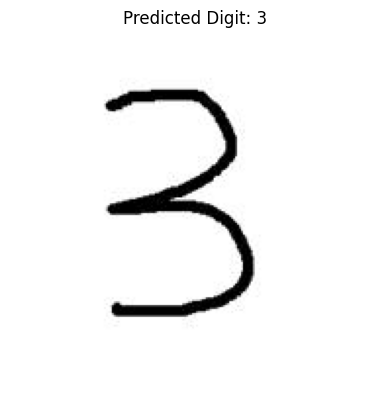

In [20]:
# 显示图片并预测
plt.imshow(Image.open(uploaded_image_path), cmap='gray')
plt.axis('off')
predicted_digit = predict(uploaded_image_path)
plt.title(f"Predicted Digit: {predicted_digit}")
plt.show()